# Starbucks Capstone Challenge

# Table of contents
1.  [Section 1: Project Definition](#ProjectDefinition) <br />
2. [Section 2: Analysis](#analysis)<br />
3. [Section 3: Implementation](#Methodology)<br />
4. [Section 4: Results](#results)<br />
5. [Section 5: Conclusion](#conclusion)


# Section 1: Project Definition <a name="ProjectDefinition"></a>

This project forms part of the final project in Udacity’s data science Nanodegree course. Starbuck’s has provided some simulated data from a series of offers they are promoting to their customers on their rewards mobile app. They have 3 types of offers:

* buy-one-get-one (BOGO) - a user needs to spend a certain amount to get a reward equal to that threshold amount. 
* In a discount, a user gains a reward equal to a fraction of the amount spent. 
* In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend

Not all customers receive the same offer. Certain customers may not be influenced by a certain offer they receive. Some users may not even look at the offers they receive, but will spend money in the offer’s validity period regardless. 

The aim of this project is to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer. This will be done by breaking up the problem into 3 key areas:


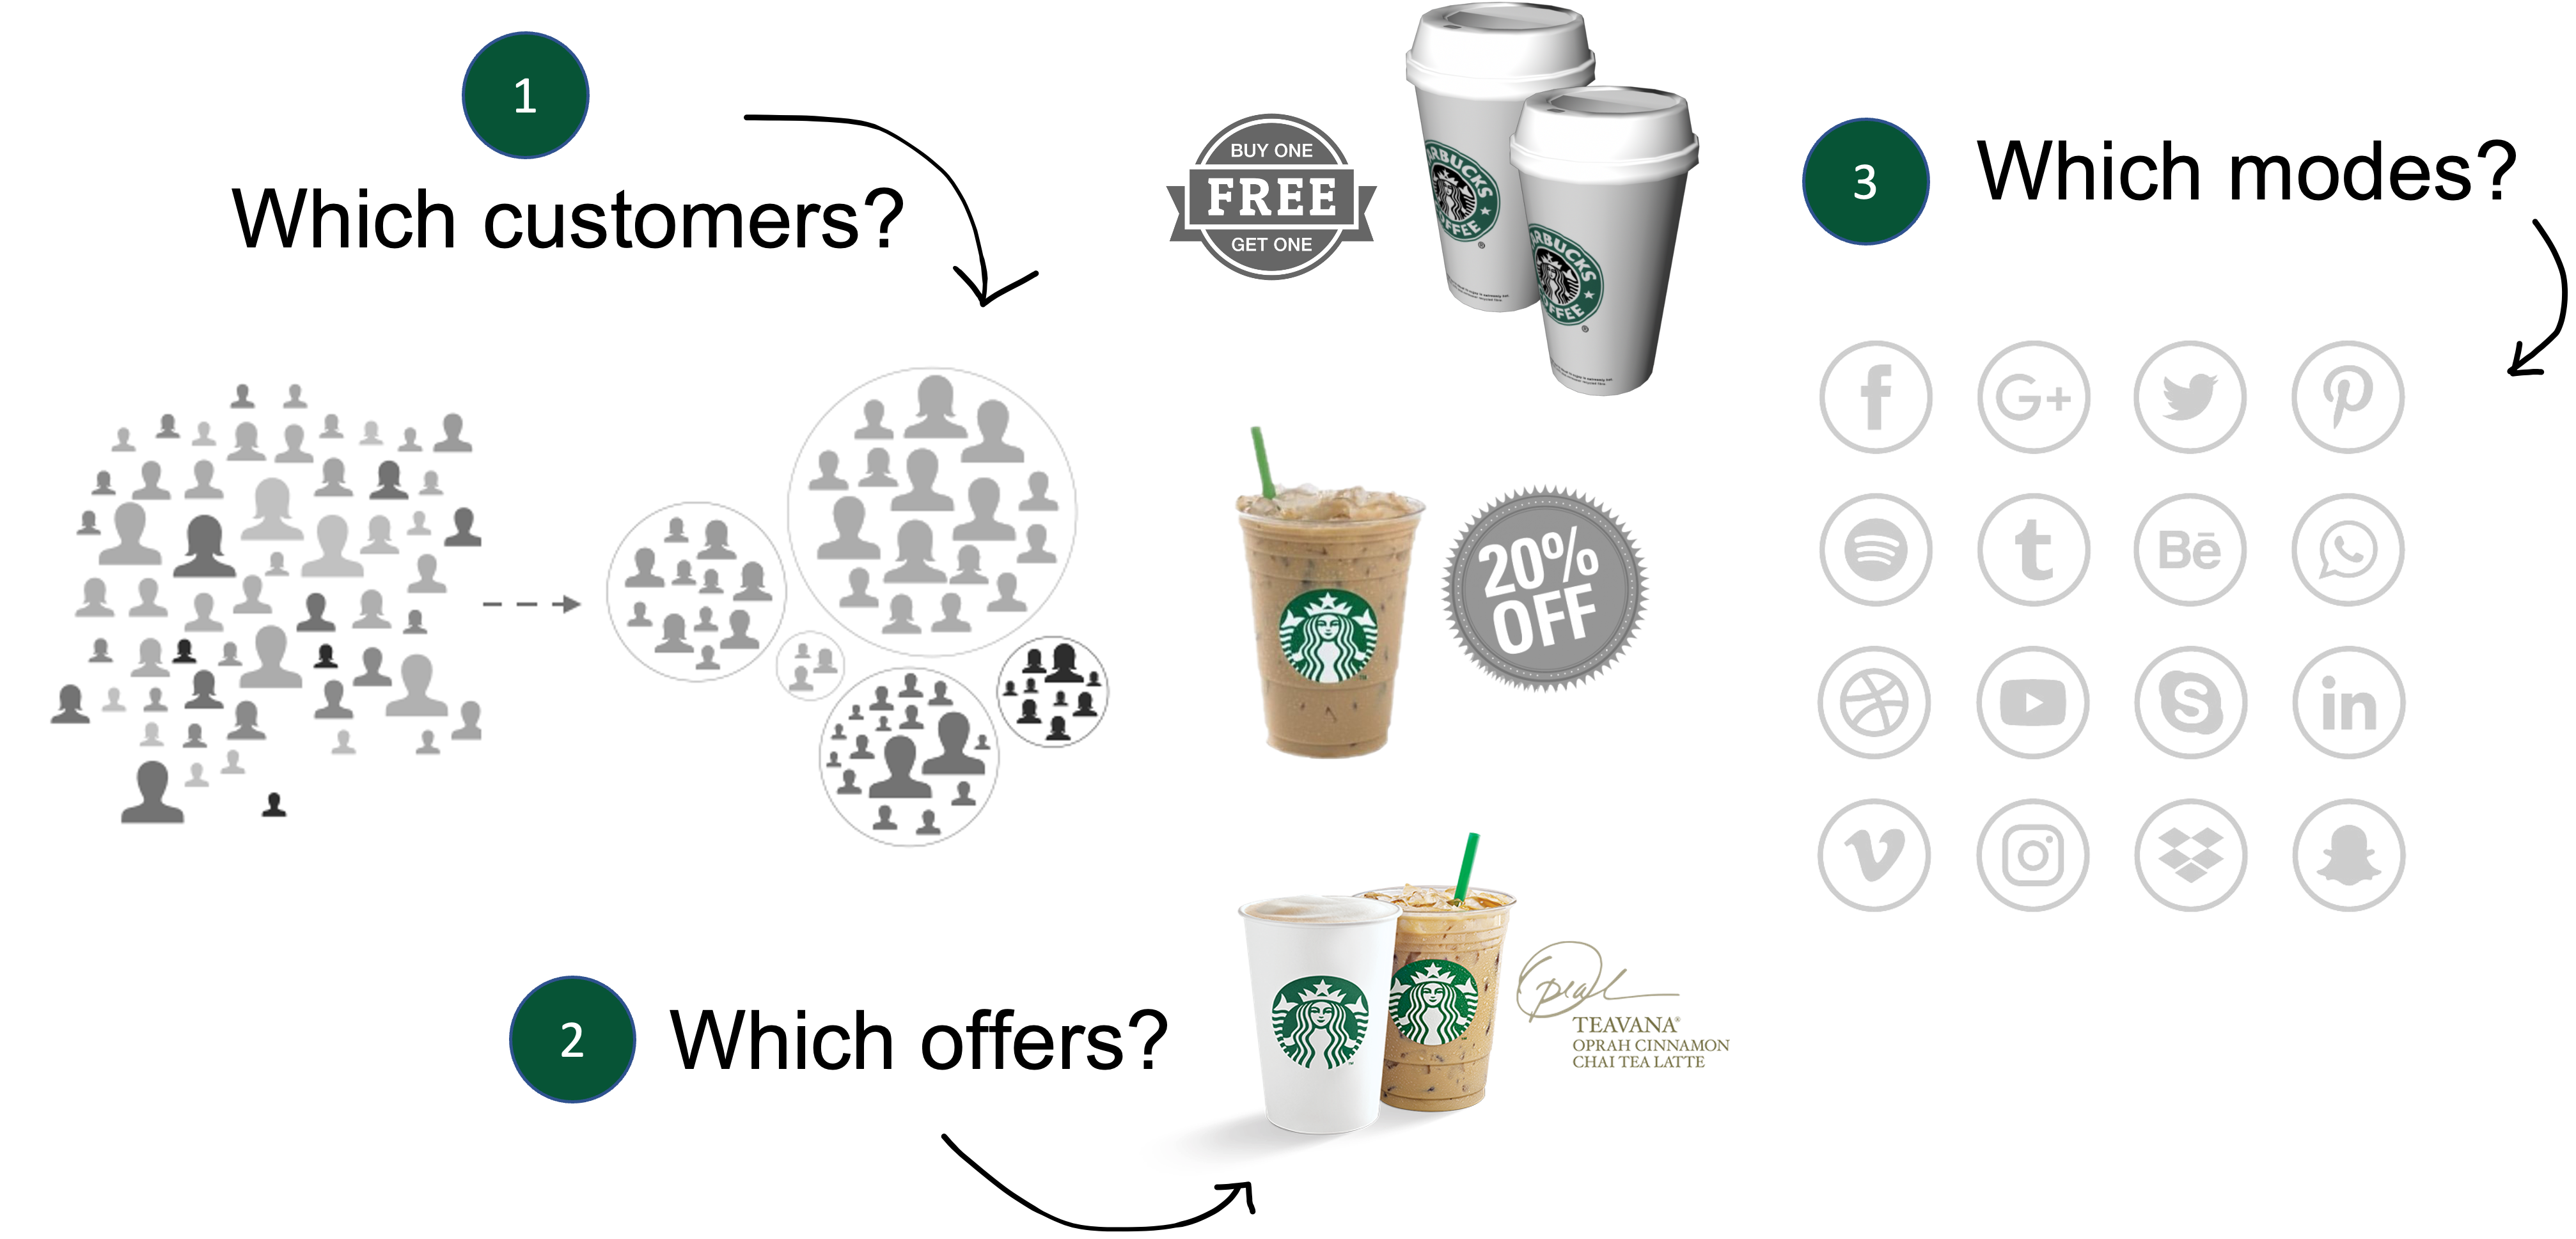

**1. Which customers?**

The customers will need to be segmented in some way based on a combination of their features and behaviours. 

A **silhouette score** will be used to evaluate the quality of clusters resulting from the segmentation algorithm i.e. how dense and well-separated the clusters are. 

**2. Which offers?**

A **response rate** will need to be calculated for each offer, and each customer segment:

    Response rate = number of offers completed / number of offers sent

This metric is not applicable to the informational offers, therefore another metric will be used: **influenced spend**: How influential the offer was in terms of spend. How much money can we expect from the offer on average?

    Influenced spend = Spend in validity period / number of offers sent

**3. Which modes?**

**Response rate** can be used again to see which forms of advertising work best. 
To determine which platforms people are using the most, where they are most likely to see the offer as soon as it is posted:

    Time to view = offer sent - offer viewed  

How accessible is the offer? How well does the offer call to action? How easy is it to go out and complete the offer once a customer has viewed it

    Time to complete = offer completed - offer viewed 


# Section 2: Analysis <a name="analysis"></a>

In [1]:
# import relevant packages

import pandas as pd
import numpy as np
import math
import json
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(sns.__version__) 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import silhouette_score
import plotly.express as px
from yellowbrick.cluster import SilhouetteVisualizer

0.12.0


The data is contained in three files:

* **1. portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
* **2. profile.json** - demographic data for each customer
* **3. transcript.json** - records for transactions, offers received, offers viewed, and offers completed

In this section, I will explore each data set. Some basic cleaning will be done to merge the datasets.

**1. portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
# read in the json file
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# Convert duration from days to hours 

portfolio['duration'] = portfolio['duration'] * 24

# Assign each offer a new label

offer_labels = ['b1','b2', 'i1', 'b3', 'd1', 'd2', 'd3', 'i2', 'b4', 'd5']

portfolio = portfolio.assign(offer_label = offer_labels)

# Make id name consistent

portfolio['offer_id'] = portfolio['id']

# convert channels list into string

def channels(channel_list):
    '''
    returns a string of channels in alphabetical order
    input:
        channel list: list of channels
    output:
        joined list: list converted into a string in alphabetical order
    '''
        
    joined_list = sorted(channel_list)
    joined_list = " ".join(joined_list)
    return joined_list
    
portfolio['channel_string'] = portfolio['channels'].apply(lambda x: channels(list(x)))

# Remove unecessary columns

portfolio.drop(['id', 'channels'], axis = 1, inplace = True)
portfolio

,reward,difficulty,duration,offer_type,offer_label,offer_id,channel_string
0,10,10,168,bogo,b1,ae264e3637204a6fb9bb56bc8210ddfd,email mobile social
1,10,10,120,bogo,b2,4d5c57ea9a6940dd891ad53e9dbe8da0,email mobile social web
2,0,0,96,informational,i1,3f207df678b143eea3cee63160fa8bed,email mobile web
3,5,5,168,bogo,b3,9b98b8c7a33c4b65b9aebfe6a799e6d9,email mobile web
4,5,20,240,discount,d1,0b1e1539f2cc45b7b9fa7c272da2e1d7,email web
5,3,7,168,discount,d2,2298d6c36e964ae4a3e7e9706d1fb8c2,email mobile social web
6,2,10,240,discount,d3,fafdcd668e3743c1bb461111dcafc2a4,email mobile social web
7,0,0,72,informational,i2,5a8bc65990b245e5a138643cd4eb9837,email mobile social
8,5,5,120,bogo,b4,f19421c1d4aa40978ebb69ca19b0e20d,email mobile social web
9,2,10,168,discount,d5,2906b810c7d4411798c6938adc9daaa5,email mobile web


**2. profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [4]:
# read in the json file
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
# Make id name consistent

profile['person_id'] = profile['id']

#Convert 'became_member_on' to DATE

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Determine membership length (years)

profile['today'] = '2018-07-30' # Assuming this is when the analysis takes place
profile['today'] = pd.to_datetime(profile['today'])

profile['membership_length'] = (profile['today'] - profile['became_member_on']).dt.days / 365

# Remove unecessary columns

profile.drop(['became_member_on', 'id', 'today'], axis = 1, inplace = True)

profile

,gender,age,income,person_id,membership_length
0,None,118,NaN,68be06ca386d4c31939f3a4f0e3dd783,1.460274
1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,1.041096
2,None,118,NaN,38fe809add3b4fcf9315a9694bb96ff5,0.049315
3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,1.224658
4,None,118,NaN,a03223e636434f42ac4c3df47e8bac43,0.986301
...,...,...,...,...,...
16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,0.153425
16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,0.046575
16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,1.506849
16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,2.397260


In [6]:
profile[profile['age'] < 118].describe()

,age,income,membership_length
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1.442408
std,17.383705,21598.299410,1.148507
min,18.000000,30000.000000,0.010959
25%,42.000000,49000.000000,0.580822
50%,55.000000,64000.000000,0.991781
75%,66.000000,80000.000000,2.194521
max,101.000000,120000.000000,5.005479


**3. transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [7]:
# read in the json file
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [8]:
# Make id name consistent

transcript['person_id'] = transcript['person']

# Remove unecessary columns

transcript.drop(['person'], axis = 1, inplace = True)
transcript

,event,value,time,person_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,78afa995795e4d85b5d9ceeca43f5fef
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,a03223e636434f42ac4c3df47e8bac43
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,e2127556f4f64592b11af22de27a7932
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,8ec6ce2a7e7949b1bf142def7d0e0586
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,68617ca6246f4fbc85e91a2a49552598
...,...,...,...,...
306529,transaction,{'amount': 1.5899999999999999},714,b3a1272bc9904337b331bf348c3e8c17
306530,transaction,{'amount': 9.53},714,68213b08d99a4ae1b0dcb72aebd9aa35
306531,transaction,{'amount': 3.61},714,a00058cf10334a308c68e7631c529907
306532,transaction,{'amount': 3.5300000000000002},714,76ddbd6576844afe811f1a3c0fbb5bec


Since the transcript contains both transactions and offers we are going to split it into 2 datasets 

In [9]:
# Get transactions

transactions = transcript[transcript['event'] == 'transaction']
transactions['amount'] = transactions['value'].apply(lambda x: x.get('amount'))
transactions.drop(['value', 'event'], axis = 1, inplace = True)

transactions.head()

/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_2774/3448623626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['amount'] = transactions['value'].apply(lambda x: x.get('amount'))
/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_2774/3448623626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions.drop(['value', 'event'], axis = 1, inplace = True)


,time,person_id,amount
12654,0,02c083884c7d45b39cc68e1314fec56c,0.83
12657,0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
12659,0,54890f68699049c2a04d415abc25e717,13.23
12670,0,b2f1cd155b864803ad8334cdf13c4bd2,19.51
12671,0,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [10]:
# Get total spend and total transactions per customer

person_sum = transactions.groupby(['person_id']).agg({'amount' : 'sum', 'time' : 'count'})
person_sum['total_spend'] = person_sum['amount']
person_sum['total_transactions'] = person_sum['time']
person_sum = person_sum.reset_index()
profile = pd.merge(profile, person_sum[['person_id', 'total_spend', 'total_transactions']], 
                   on = 'person_id', how = 'left')
profile

,gender,age,income,person_id,membership_length,total_spend,total_transactions
0,None,118,NaN,68be06ca386d4c31939f3a4f0e3dd783,1.460274,20.40,9.0
1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,1.041096,77.01,3.0
2,None,118,NaN,38fe809add3b4fcf9315a9694bb96ff5,0.049315,14.30,6.0
3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,1.224658,159.27,7.0
4,None,118,NaN,a03223e636434f42ac4c3df47e8bac43,0.986301,4.65,3.0
...,...,...,...,...,...,...,...
16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,0.153425,20.03,7.0
16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,0.046575,25.97,7.0
16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,1.506849,39.74,8.0
16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,2.397260,189.67,14.0


In [11]:
# Get offers

offers = transcript[transcript['event'] != 'transaction']
offers.head()

,event,value,time,person_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,78afa995795e4d85b5d9ceeca43f5fef
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,a03223e636434f42ac4c3df47e8bac43
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,e2127556f4f64592b11af22de27a7932
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,8ec6ce2a7e7949b1bf142def7d0e0586
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,68617ca6246f4fbc85e91a2a49552598


In [12]:
# Extract the offer ID from the dictionary

def get_offerID(x):
    ''' 
    Extract the offer id from the dictionary
    Input: 
        x: dictionary
    Output: 
        offer id
    '''
    try:
        return x['offer id']
    except:
        return x['offer_id']

offers['offer_id'] = offers['value'].apply(lambda x: get_offerID(x))

# Remove unnessary columns

offers.drop(['value'], axis = 1, inplace = True)

offers

/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_2774/885707138.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers['offer_id'] = offers['value'].apply(lambda x: get_offerID(x))
/var/folders/67/jgz6df654fv9n3yp6bkjl9f8ry5zws/T/ipykernel_2774/885707138.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers.drop(['value'], axis = 1, inplace = True)


,event,time,person_id,offer_id
0,offer received,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,offer completed,714,a6f84f4e976f44508c358cc9aba6d2b3,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,offer completed,714,b895c57e8cd047a8872ce02aa54759d6,fafdcd668e3743c1bb461111dcafc2a4
306507,offer viewed,714,8dda575c2a1d44b9ac8e8b07b93d1f8e,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,offer completed,714,8431c16f8e1d440880db371a68f82dd0,fafdcd668e3743c1bb461111dcafc2a4


In [13]:
# Pivot data to get offer timestamps in columns

person_offer = pd.pivot_table(offers, values ='time', index =['person_id', 'offer_id'],
                         columns =['event'], aggfunc = np.sum).reset_index()
person_offer.head()

event,person_id,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0


In [14]:
# Merge person and portfolio data to offers

consolidated = pd.merge(person_offer, portfolio, on='offer_id', how = 'left')
consolidated = pd.merge(consolidated, profile, on='person_id', how = 'left')
consolidated.head()

,person_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,offer_type,offer_label,channel_string,gender,age,income,membership_length,total_spend,total_transactions
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,2,10,168,discount,d5,email mobile web,M,33,72000.0,1.273973,127.6,8.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,0,96,informational,i1,email mobile web,M,33,72000.0,1.273973,127.6,8.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,0,72,informational,i2,email mobile social,M,33,72000.0,1.273973,127.6,8.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,120,bogo,b4,email mobile social web,M,33,72000.0,1.273973,127.6,8.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,2,10,240,discount,d3,email mobile social web,M,33,72000.0,1.273973,127.6,8.0


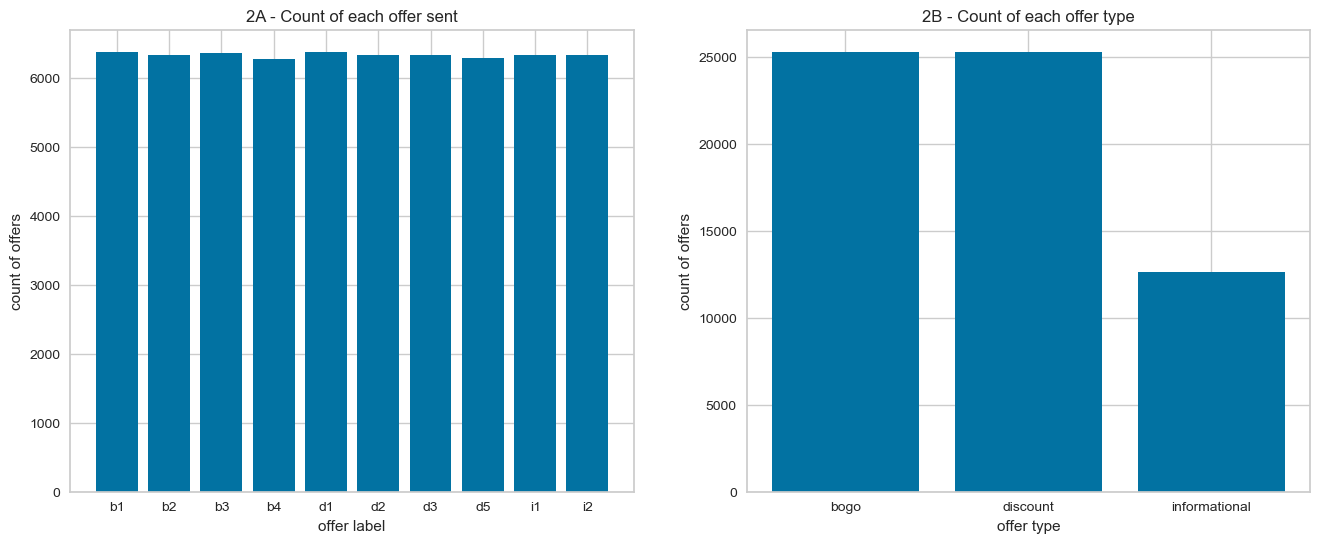

In [15]:
# Visualise offers sent data

plt.figure(figsize=(16,6))

plt.subplot(121)

offers_count = consolidated.groupby(['offer_label']).count()['person_id'].reset_index()

plt.bar(offers_count['offer_label'], offers_count['person_id'])
plt.title('2A - Count of each offer sent')
plt.xlabel("offer label")
plt.ylabel("count of offers")
ax = plt.gca()

plt.subplot(122)

offer_type_count = consolidated.groupby(['offer_type']).count()['person_id'].reset_index()

plt.bar(offer_type_count['offer_type'], offer_type_count['person_id'])
plt.title('2B - Count of each offer type')
plt.xlabel("offer type")
plt.ylabel("count of offers")
ax = plt.gca()

* Figure 2A - Relatively the same volume of each offer was sent out to the customers. A customer is therefore equally likely to receive any of the 10 offers
* Figure 2B - The total number of bogos and discounts sent out are same, while informational offers make up about only half of those amounts. A customer is therefore less likely to receive an informational offer than a bogo or discount. 

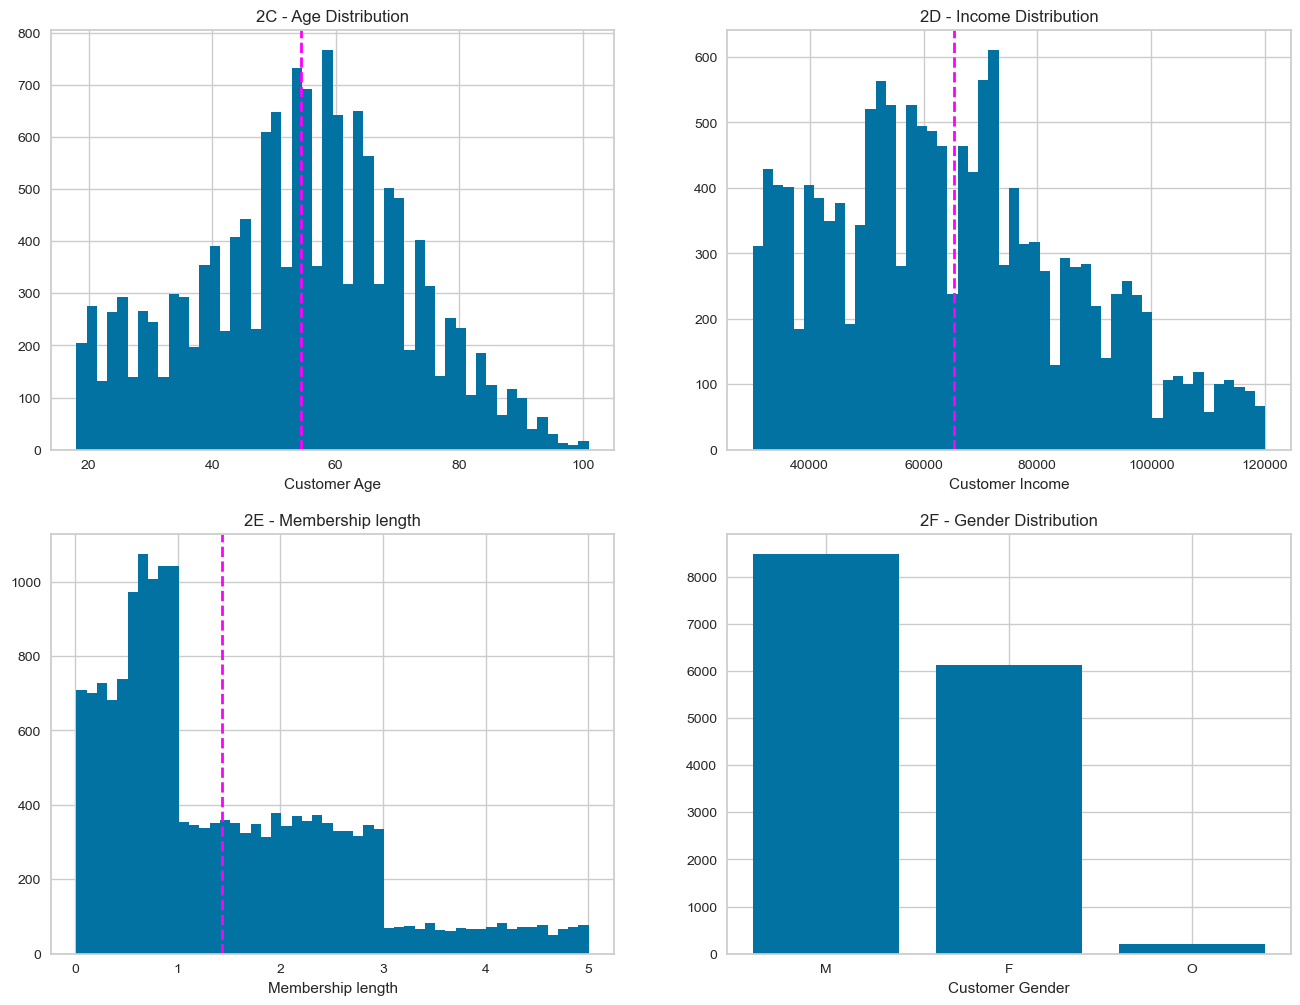

In [16]:
# Visualise demographic data

plt.figure(figsize=(16,12))

valid_ages = profile[profile["age"] < 118]

plt.subplot(221)
plt.hist(valid_ages["age"], bins = 50)
plt.axvline(valid_ages["age"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2C - Age Distribution')
plt.xlabel("Customer Age")
ax = plt.gca()

plt.subplot(222)
plt.hist(profile["income"], bins = 50)
plt.axvline(profile["income"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2D - Income Distribution')
plt.xlabel("Customer Income")
ax = plt.gca()

plt.subplot(223)
plt.hist(profile["membership_length"], bins = 50)
plt.axvline(profile["membership_length"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2E - Membership length')
plt.xlabel("Membership length")
ax = plt.gca()

genders = profile.gender.value_counts()

plt.subplot(224)
plt.bar(genders.index, genders.values)
plt.title('2F - Gender Distribution')
plt.xlabel("Customer Gender")
ax = plt.gca()

* Figure 2C - Starbucks has a customer base with a normal age distribution. Customer ages range from 18 to 101, and have an average of about 54 years. It is interesting to see that there is portion of older people using the mobile app, as generally these technological marketing schemes are aimed at younger people. 
* Figure 2D - Starbucks customers earn on average 65,400 with a slightly right skewed distribution
* Figure 2E - The majority of the customers have only joined the rewards mobile app in the last year, but there is a small group of loyal customers who have been a member for over 3 years
* Figure 2F - Males make up most of the customer base, and there is a small group of people who are identify as 'other'

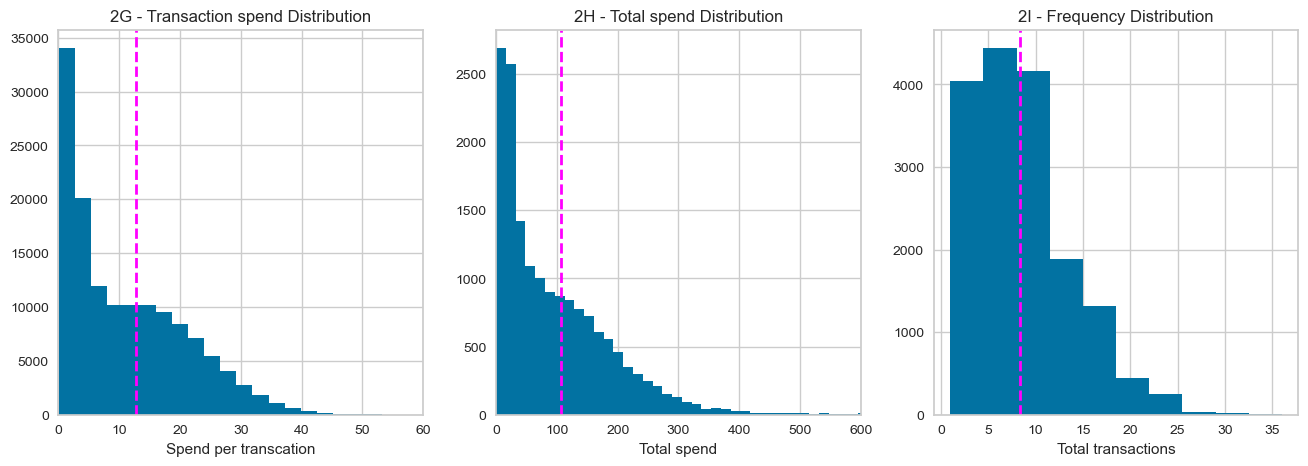

In [17]:
# Visualise customer's spend distribution 

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.hist(transactions["amount"], bins = 400)
plt.axvline(transactions["amount"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2G - Transaction spend Distribution')
plt.xlabel("Spend per transcation")
ax = plt.gca()
ax.set_xlim(0,60);

plt.subplot(132)
plt.hist(profile["total_spend"], bins = 100)
plt.axvline(profile["total_spend"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2H - Total spend Distribution')
plt.xlabel("Total spend")
ax = plt.gca()
ax.set_xlim(0,600);

plt.subplot(133)
plt.hist(profile["total_transactions"])
plt.axvline(profile["total_transactions"].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.title('2I - Frequency Distribution')
plt.xlabel("Total transactions")
ax = plt.gca()

* Figure 2G - It looks a customer will spend 12 dollars on an average transaction, however the majority of transactions are less than 5 dollars
* Figure 2H - Within the 30 days of the simulation, customers have spent on average a total of just over 100 dollars
* Figure 2I - Using the metric of total transactions we can see how frequently a customer is making purchases. Most customers have made between 1 - 12 purchases during the period of simulation. 

# Section 3: Implementation <a name="Methodology"></a>

In this section we will calculate some additional columns which will assist in building our clustering model:

1. Determine if the offer was succesful
2. Calculate influenced spend
3. Calculate time to view offer
4. Calculate time to complete offer


An offer could have an 'offer complete' timestamp but this does not mean the customer was actually influenced by the offer - they may have only viewed it after spending to complete the offer, or might have not seen it at all.

We therefore need to determine whether the data in the 'offer complete' column is actually valid, by introducing a new column called 'offer_success'. We consider the offer succesful if the customer has viewed the offer before it is completed, and if they view it within the validty period. 

In [18]:
# Determine offer validity period for each offer sent 

consolidated['offer end'] = consolidated['offer received'] +  consolidated['duration']

# Was the offer succesful?

def offer_success(offer_completed, offer_received, offer_viewed, offer_end):
    '''
    determines whether offer was a success depending if customer viewed 
    the offer and completed it within the validy period
    input:
        offer_completed: time offer was completed
        offer_received: time offer was received
        offer_viewed: time offer was viewed
        offer_end: time offer validity period ends
    output:
        binary: 1 if succesful, 0 if unsuccesful
    
    '''
    
    if offer_completed > 0:
    
        if (offer_viewed > offer_received) &  (offer_viewed < offer_end) & (offer_viewed < offer_completed):
            return 1
        else:
            return 0
    
    else:
        return 0

consolidated['offer_success'] = consolidated.apply(lambda x : offer_success(x['offer completed'], x['offer received'], 
                                                                     x['offer viewed'], x['offer end']), axis = 1)

consolidated.head()

,person_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,offer_type,offer_label,channel_string,gender,age,income,membership_length,total_spend,total_transactions,offer end,offer_success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,2,10,168,discount,d5,email mobile web,M,33,72000.0,1.273973,127.6,8.0,744.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,0,96,informational,i1,email mobile web,M,33,72000.0,1.273973,127.6,8.0,432.0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,0,72,informational,i2,email mobile social,M,33,72000.0,1.273973,127.6,8.0,240.0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,120,bogo,b4,email mobile social web,M,33,72000.0,1.273973,127.6,8.0,528.0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,2,10,240,discount,d3,email mobile social web,M,33,72000.0,1.273973,127.6,8.0,744.0,0


A customer may spend money, without actually knowing there was a special offer on what they purchased. We need to determine how much of their spend was actually influenced by the offer. If the customer spent money after viewing the offer, and within the validity period of that offer, we can assume that it was actually influenced by the offer. 

In [19]:
# Calculate influenced spend

def spend(transactions, person, start, end):
    '''
    returns total spend for a parituclar person within a given time frame
    input:
        transactions: transactions dataframe
        person: person id
        start: start time
        end: end time
    output:
        spend: float value for total spend within the time period
    '''
    spend = transactions.loc[(transactions['person_id'] == person) & (transactions['time'] > start) 
                     & (transactions['time'] < end), 'amount'].sum()
    
    return spend

consolidated['influenced_spend'] = consolidated.apply(lambda x : spend(transactions, x['person_id'], x['offer viewed'], x['offer end']), axis = 1)

consolidated.head()
    

,person_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,offer_type,offer_label,channel_string,gender,age,income,membership_length,total_spend,total_transactions,offer end,offer_success,influenced_spend
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,2,10,168,discount,d5,email mobile web,M,33,72000.0,1.273973,127.6,8.0,744.0,0,0.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,0,96,informational,i1,email mobile web,M,33,72000.0,1.273973,127.6,8.0,432.0,0,8.57
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,0,72,informational,i2,email mobile social,M,33,72000.0,1.273973,127.6,8.0,240.0,0,22.16
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,120,bogo,b4,email mobile social web,M,33,72000.0,1.273973,127.6,8.0,528.0,0,0.00
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,2,10,240,discount,d3,email mobile social web,M,33,72000.0,1.273973,127.6,8.0,744.0,0,82.76


In [20]:
# Ensure there are no missing values for income

profile_clustering = profile[profile['total_spend'] > 0]
profile_clustering = profile_clustering[profile_clustering['age'] < 118]
profile_clustering

,gender,age,income,person_id,membership_length,total_spend,total_transactions
1,F,55,112000.0,0610b486422d4921ae7d2bf64640c50b,1.041096,77.01,3.0
3,F,75,100000.0,78afa995795e4d85b5d9ceeca43f5fef,1.224658,159.27,7.0
5,M,68,70000.0,e2127556f4f64592b11af22de27a7932,0.260274,57.73,3.0
8,M,65,53000.0,389bc3fa690240e798340f5a15918d5c,0.468493,36.43,3.0
12,M,58,51000.0,2eeac8d8feae4a8cad5a6af0499a211d,0.715068,15.62,4.0
...,...,...,...,...,...,...,...
16995,F,45,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,0.153425,20.03,7.0
16996,M,61,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,0.046575,25.97,7.0
16997,M,49,73000.0,01d26f638c274aa0b965d24cefe3183f,1.506849,39.74,8.0
16998,F,83,50000.0,9dc1421481194dcd9400aec7c9ae6366,2.397260,189.67,14.0


In [21]:
# Calculate time to view, and time to complete the offer

consolidated['time_to_view'] = consolidated['offer viewed'] -  consolidated['offer received']
consolidated['time_to_complete'] = consolidated['offer completed'] -  consolidated['offer viewed']
consolidated

,person_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,offer_type,offer_label,...,age,income,membership_length,total_spend,total_transactions,offer end,offer_success,influenced_spend,time_to_view,time_to_complete
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,2,10,168,discount,d5,...,33,72000.0,1.273973,127.60,8.0,744.0,0,0.00,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,0,96,informational,i1,...,33,72000.0,1.273973,127.60,8.0,432.0,0,8.57,36.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,0,72,informational,i2,...,33,72000.0,1.273973,127.60,8.0,240.0,0,22.16,24.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,120,bogo,b4,...,33,72000.0,1.273973,127.60,8.0,528.0,0,0.00,48.0,-42.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,2,10,240,discount,d3,...,33,72000.0,1.273973,127.60,8.0,744.0,0,82.76,36.0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,552.0,408.0,516.0,5,5,120,bogo,b4,...,34,34000.0,1.515068,88.83,12.0,528.0,1,0.00,108.0,36.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,198.0,168.0,174.0,5,20,240,discount,d1,...,45,62000.0,1.676712,226.07,15.0,408.0,1,111.94,6.0,24.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1374.0,1320.0,1350.0,2,10,168,discount,d5,...,45,62000.0,1.676712,226.07,15.0,1488.0,1,0.00,30.0,24.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,504.0,534.0,5,5,168,bogo,b3,...,45,62000.0,1.676712,226.07,15.0,672.0,0,43.26,30.0,-30.0


In order to determine which groups of people respond best to each offer, we need to group the customers into segments based on their similar features or behaviour i.e. ages, income, spend, gender etc. The unsupervised machine learning model, *KMeans*, will be used to do this. 

In [22]:
# Get features normally distributed and scaled

features = profile_clustering[["age", 'total_transactions', 'income']]
features_log = np.log(features)
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features_log)

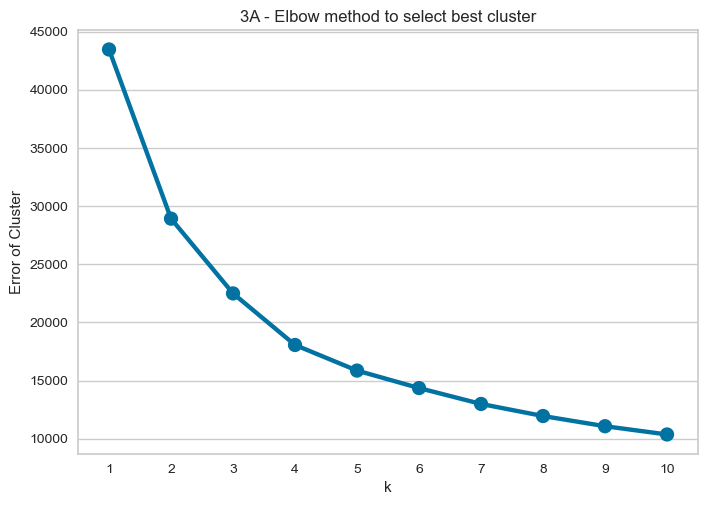

In [23]:
# Elbow method to select best cluster

errors = []

for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(features_scaled)
    errors.append(model.inertia_)
    
plt.title('3A - Elbow method to select best cluster')
plt.xlabel('k')
plt.ylabel('Error of Cluster')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.show()

* Figure 3A - 

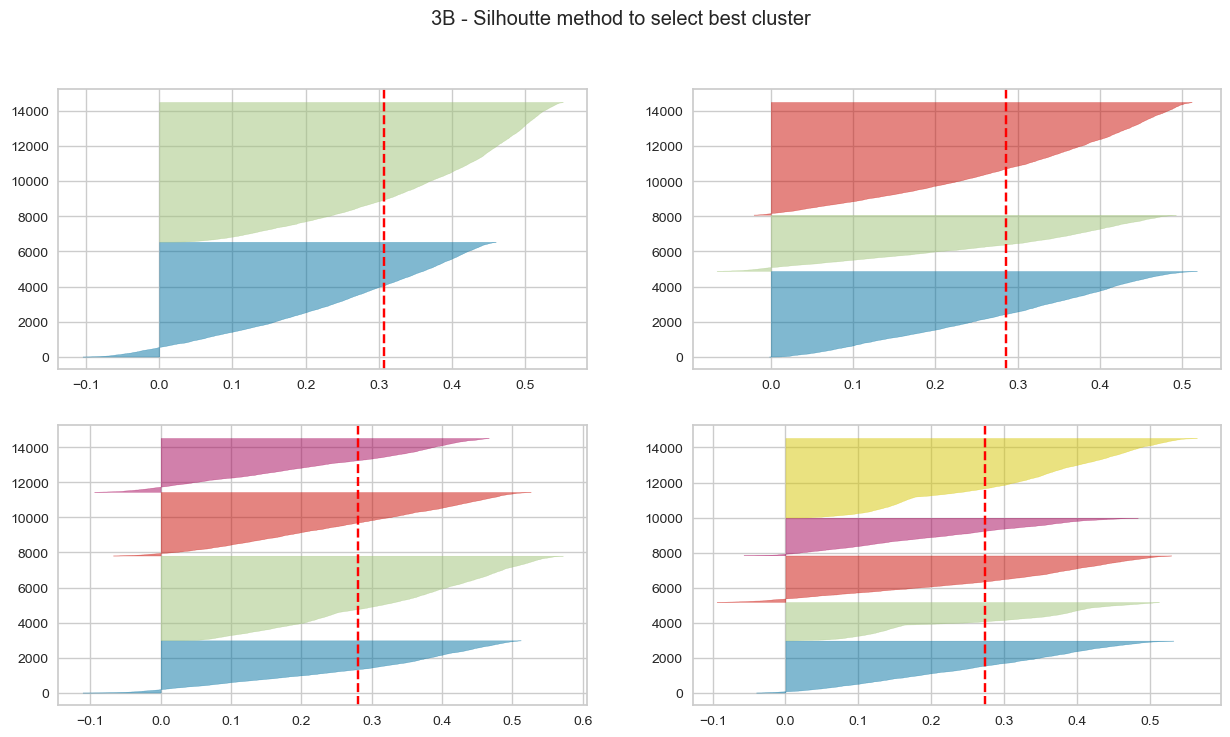

In [24]:
# Silhoutte method to select best cluster

fig, ax = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('3B - Silhoutte method to select best cluster')

for i in [2, 3, 4, 5]:

    #Create KMeans instance for different number of clusters

    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    
    #Create SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(features_scaled)

* Figure 3B - For n = 3, all 3 clusters are above the average silhoutte scores and they are closer in size and thickness than the other clusters. There are also fewer data points that fall below zero. The silhoutte score should ideally be closer to 1 as this means the clusters are dense and well-separated. A silhoutte score of 0.3 means there might be some overlapping clusters. A future improvement here could be selecting different features in the dataset to find more optimal clusters.

For now, Based on a combination of the elbow method and sihouette analysis, 3 clusters will be chosen to segment the customer base. 

In [25]:
# Build the KMeans model with 3 clusters

model = KMeans(n_clusters = 3, random_state=42)
model.fit(features_scaled)

KMeans(n_clusters=3, random_state=42)

In [26]:
# Assign cluster label to each customer

profile_clustering = profile_clustering.assign(ClusterLabel = model.labels_)

result = profile_clustering.groupby("ClusterLabel").agg({"age":"mean", 
                                                         "income":"median",
                                                         "person_id" : "count", 
                                                         'total_transactions' : 'median'}).round()

result

,age,income,person_id,total_transactions
ClusterLabel,,,,
0,60.0,52000.0,4876,11.0
1,30.0,50000.0,3194,9.0
2,62.0,82000.0,6422,5.0


There is a trend within the clusters:
- Cluster 0 represents older customers who earn moderately, and make purchases frequently
- Cluster 1 represents younger customers who earn moderately and make purchases semi-frequently
- Cluster 2 represents older customers who earn a lot but don't make a lot of purchases

In [27]:
# Add customer segments to the transaction and profile data

transactions = pd.merge(transactions, profile_clustering, on='person_id', how='left')
consolidated = consolidated.merge(profile_clustering[['ClusterLabel', 'person_id']], on='person_id', how='left')
consolidated

,person_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,offer_type,offer_label,...,income,membership_length,total_spend,total_transactions,offer end,offer_success,influenced_spend,time_to_view,time_to_complete,ClusterLabel
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,2,10,168,discount,d5,...,72000.0,1.273973,127.60,8.0,744.0,0,0.00,NaN,NaN,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,0,96,informational,i1,...,72000.0,1.273973,127.60,8.0,432.0,0,8.57,36.0,NaN,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,0,72,informational,i2,...,72000.0,1.273973,127.60,8.0,240.0,0,22.16,24.0,NaN,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,120,bogo,b4,...,72000.0,1.273973,127.60,8.0,528.0,0,0.00,48.0,-42.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,2,10,240,discount,d3,...,72000.0,1.273973,127.60,8.0,744.0,0,82.76,36.0,-12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,552.0,408.0,516.0,5,5,120,bogo,b4,...,34000.0,1.515068,88.83,12.0,528.0,1,0.00,108.0,36.0,1.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,198.0,168.0,174.0,5,20,240,discount,d1,...,62000.0,1.676712,226.07,15.0,408.0,1,111.94,6.0,24.0,0.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1374.0,1320.0,1350.0,2,10,168,discount,d5,...,62000.0,1.676712,226.07,15.0,1488.0,1,0.00,30.0,24.0,0.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,504.0,534.0,5,5,168,bogo,b3,...,62000.0,1.676712,226.07,15.0,672.0,0,43.26,30.0,-30.0,0.0


# Section 4: Results <a name="results"></a>

A repsonse rate will be calculated for each offer which is determined by the number of offers that were succesful vs. the number of offers that were sent out 

In [28]:
# Calculate reponse rate for offers

response = consolidated.groupby(['offer_type', 'ClusterLabel']).agg({"person_id":"count", 
                                                        "influenced_spend": "sum", 
                                                        "offer_success":'sum'}).reset_index()

response['response_rate'] = response['offer_success'] / response['person_id']
response['Offer_spend'] = response['influenced_spend'] / response['person_id']

response

,offer_type,ClusterLabel,person_id,influenced_spend,offer_success,response_rate,Offer_spend
0,bogo,0.0,7413,159088.75,1912,0.257925,21.460778
1,bogo,1.0,4804,76959.26,941,0.195878,16.019829
2,bogo,2.0,9365,213728.70,2696,0.287880,22.822072
3,discount,0.0,7420,214008.88,2508,0.338005,28.842167
4,discount,1.0,4832,85271.81,1308,0.270695,17.647312
5,discount,2.0,9348,282981.51,2872,0.307231,30.271877
6,informational,0.0,3573,35657.14,0,0.000000,9.979608
7,informational,1.0,2335,16205.82,0,0.000000,6.940394
8,informational,2.0,4897,43746.66,0,0.000000,8.933359


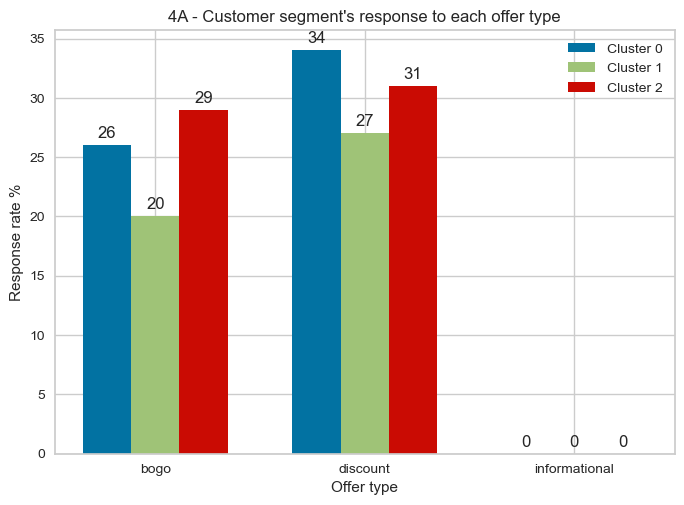

In [29]:
# Which customer segements are most responsive to each offer?

offer_type = ['bogo', 'discount', 'informational']

cluster0 = (response[response['ClusterLabel']==0]['response_rate']*100).round()
cluster1 = (response[response['ClusterLabel']==1]['response_rate']*100).round()
cluster2 = (response[response['ClusterLabel']==2]['response_rate']*100).round()

x = np.arange(len(offer_type))
width = 0.23

fig, ax = plt.subplots()
bar1 = ax.bar(x - width, cluster0, width, label = 'Cluster 0')
bar2 = ax.bar(x, cluster1, width, label = 'Cluster 1')
bar3 = ax.bar(x + width, cluster2, width, label = 'Cluster 2')

ax.bar_label(bar1, padding = 3)
ax.bar_label(bar2, padding = 3)
ax.bar_label(bar3, padding = 3)
ax.set_xticks(x)
ax.set_xticklabels(offer_type)
ax.set_ylabel('Response rate %')
ax.set_xlabel('Offer type')
ax.set_title("4A - Customer segment's response to each offer type")
ax.legend()

plt.show()

* Figure 4A: Customers across the 3 clusters repond more positively to discounts than BOGOs. 

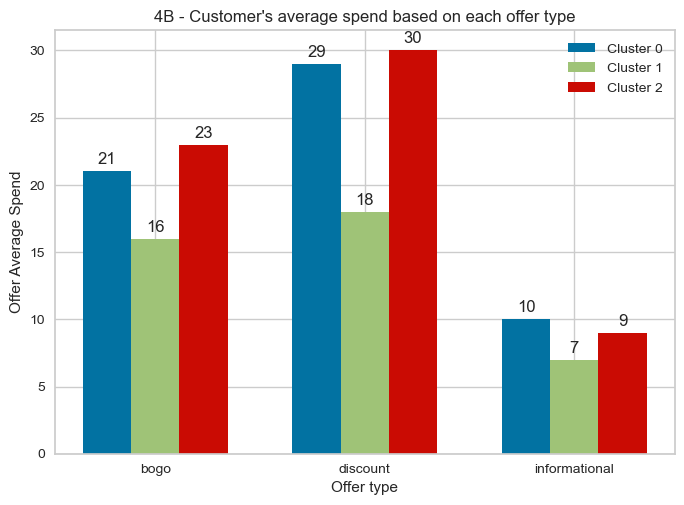

In [30]:
# Which offer types lead to the most spend?

offer_type = ['bogo', 'discount', 'informational']

cluster0 = (response[response['ClusterLabel']==0]['Offer_spend']).round()
cluster1 = (response[response['ClusterLabel']==1]['Offer_spend']).round()
cluster2 = (response[response['ClusterLabel']==2]['Offer_spend']).round()

x = np.arange(len(offer_type))
width = 0.23

fig, ax = plt.subplots()
bar1 = ax.bar(x - width, cluster0, width, label = 'Cluster 0')
bar2 = ax.bar(x, cluster1, width, label = 'Cluster 1')
bar3 = ax.bar(x + width, cluster2, width, label = 'Cluster 2')

ax.bar_label(bar1, padding = 3)
ax.bar_label(bar2, padding = 3)
ax.bar_label(bar3, padding = 3)
ax.set_xticks(x)
ax.set_xticklabels(offer_type)
ax.set_ylabel('Offer Average Spend')
ax.set_xlabel('Offer type')
ax.set_title("4B - Customer's average spend based on each offer type")
ax.legend()

plt.show()

* Figure 4B - 

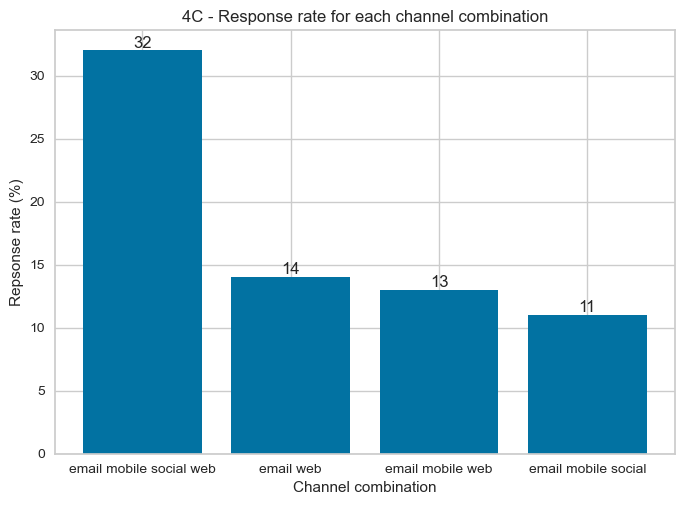

In [68]:
# Response rate depending on channels used

response_channel = consolidated.groupby(['channel_string']).agg({"person_id":"count", 
                                                        "influenced_spend": "sum", 
                                                        "offer_success":'sum'}).reset_index()

response_channel['response_rate'] = round(response_channel['offer_success'] / response_channel['person_id'] * 100,0)
response_channel = response_channel.sort_values('response_rate', ascending=False)

y = response_channel['response_rate']
x = response_channel['channel_string']

fig, ax = plt.subplots()
bars = ax.bar(x, y)
ax.set_ylabel('Repsonse rate (%)')
ax.set_xlabel('Channel combination')
ax.set_title("4C - Response rate for each channel combination")
ax.bar_label(bars)
plt.show()

* Figure 4C - a combination of email, mobile, social and web is by far the most effective way of getting customers to respond to and complete offers. The remaining 3 combinations of channels show roughly the same response rate. We will need to dig deeper to see if this is dependant on offer type. 

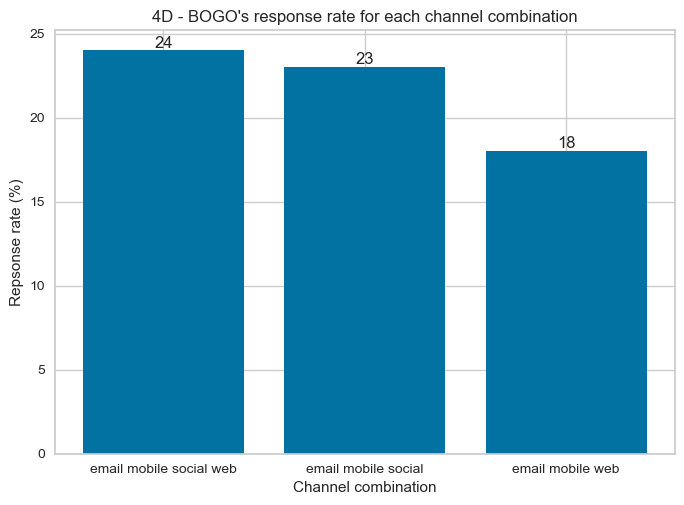

In [83]:
# How best to present bogos?

bogo = consolidated[consolidated['offer_type'] == 'bogo'].groupby(['channel_string', 'offer_type']).agg({"person_id":"count", 
                                                        "influenced_spend": "sum", 
                                                        "offer_success":'sum'}).reset_index()

bogo['response_rate'] = round(bogo['offer_success'] / bogo['person_id'] * 100, 0) 

bogo = bogo.sort_values('response_rate', ascending=False)

y = bogo['response_rate']
x = bogo['channel_string']

fig, ax = plt.subplots()
bars = ax.bar(x, y)
ax.set_ylabel('Repsonse rate (%)')
ax.set_xlabel('Channel combination')
ax.set_title("4D - BOGO's response rate for each channel combination")
ax.bar_label(bars)
plt.show()



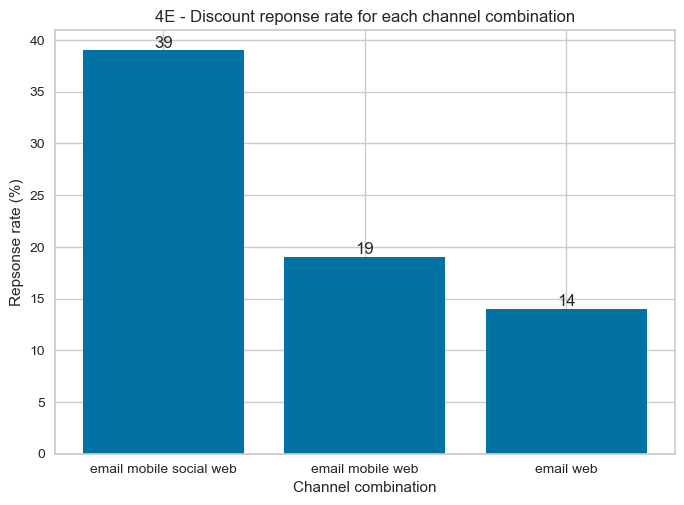

In [84]:
# How best to present discounts

discount = consolidated[consolidated['offer_type'] == 'discount'].groupby(['channel_string', 'offer_type']).agg({"person_id":"count", 
                                                        "influenced_spend": "sum", 
                                                        "offer_success":'sum'}).reset_index()

discount['response_rate'] = round(discount['offer_success'] / discount['person_id'] * 100,0)

discount = discount.sort_values('response_rate', ascending=False)

y = discount['response_rate']
x = discount['channel_string']

fig, ax = plt.subplots()
bars = ax.bar(x, y)
ax.set_ylabel('Repsonse rate (%)')
ax.set_xlabel('Channel combination')
ax.set_title("4E - Discount reponse rate for each channel combination")
ax.bar_label(bars)
plt.show()


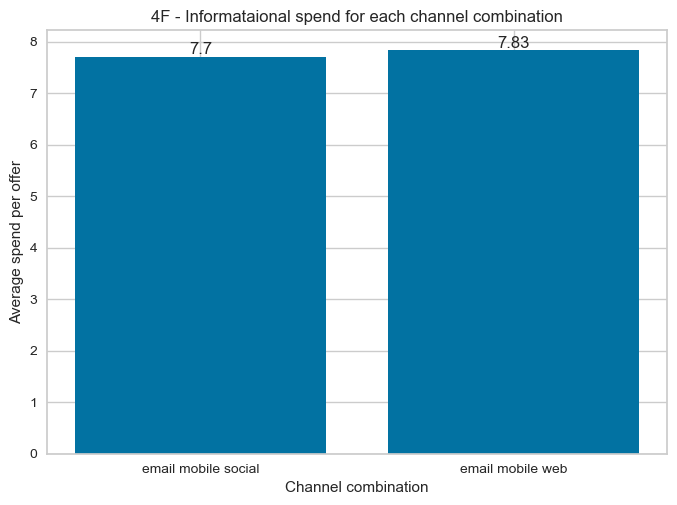

In [88]:
# How best to present informational offers

informational = consolidated[consolidated['offer_type'] == 'informational'].groupby(['channel_string', 'offer_type']).agg({"person_id":"count", 
                                                        "influenced_spend": "sum", 
                                                        "offer_success":'sum'}).reset_index()
informational['Avg. Spend'] = round(informational['influenced_spend'] / informational['person_id'],2)

y = informational['Avg. Spend']
x = informational['channel_string']

fig, ax = plt.subplots()
bars = ax.bar(x, y)
ax.set_ylabel('Average spend per offer')
ax.set_xlabel('Channel combination')
ax.set_title("4F - Informational spend for each channel combination")
ax.bar_label(bars)
plt.show()


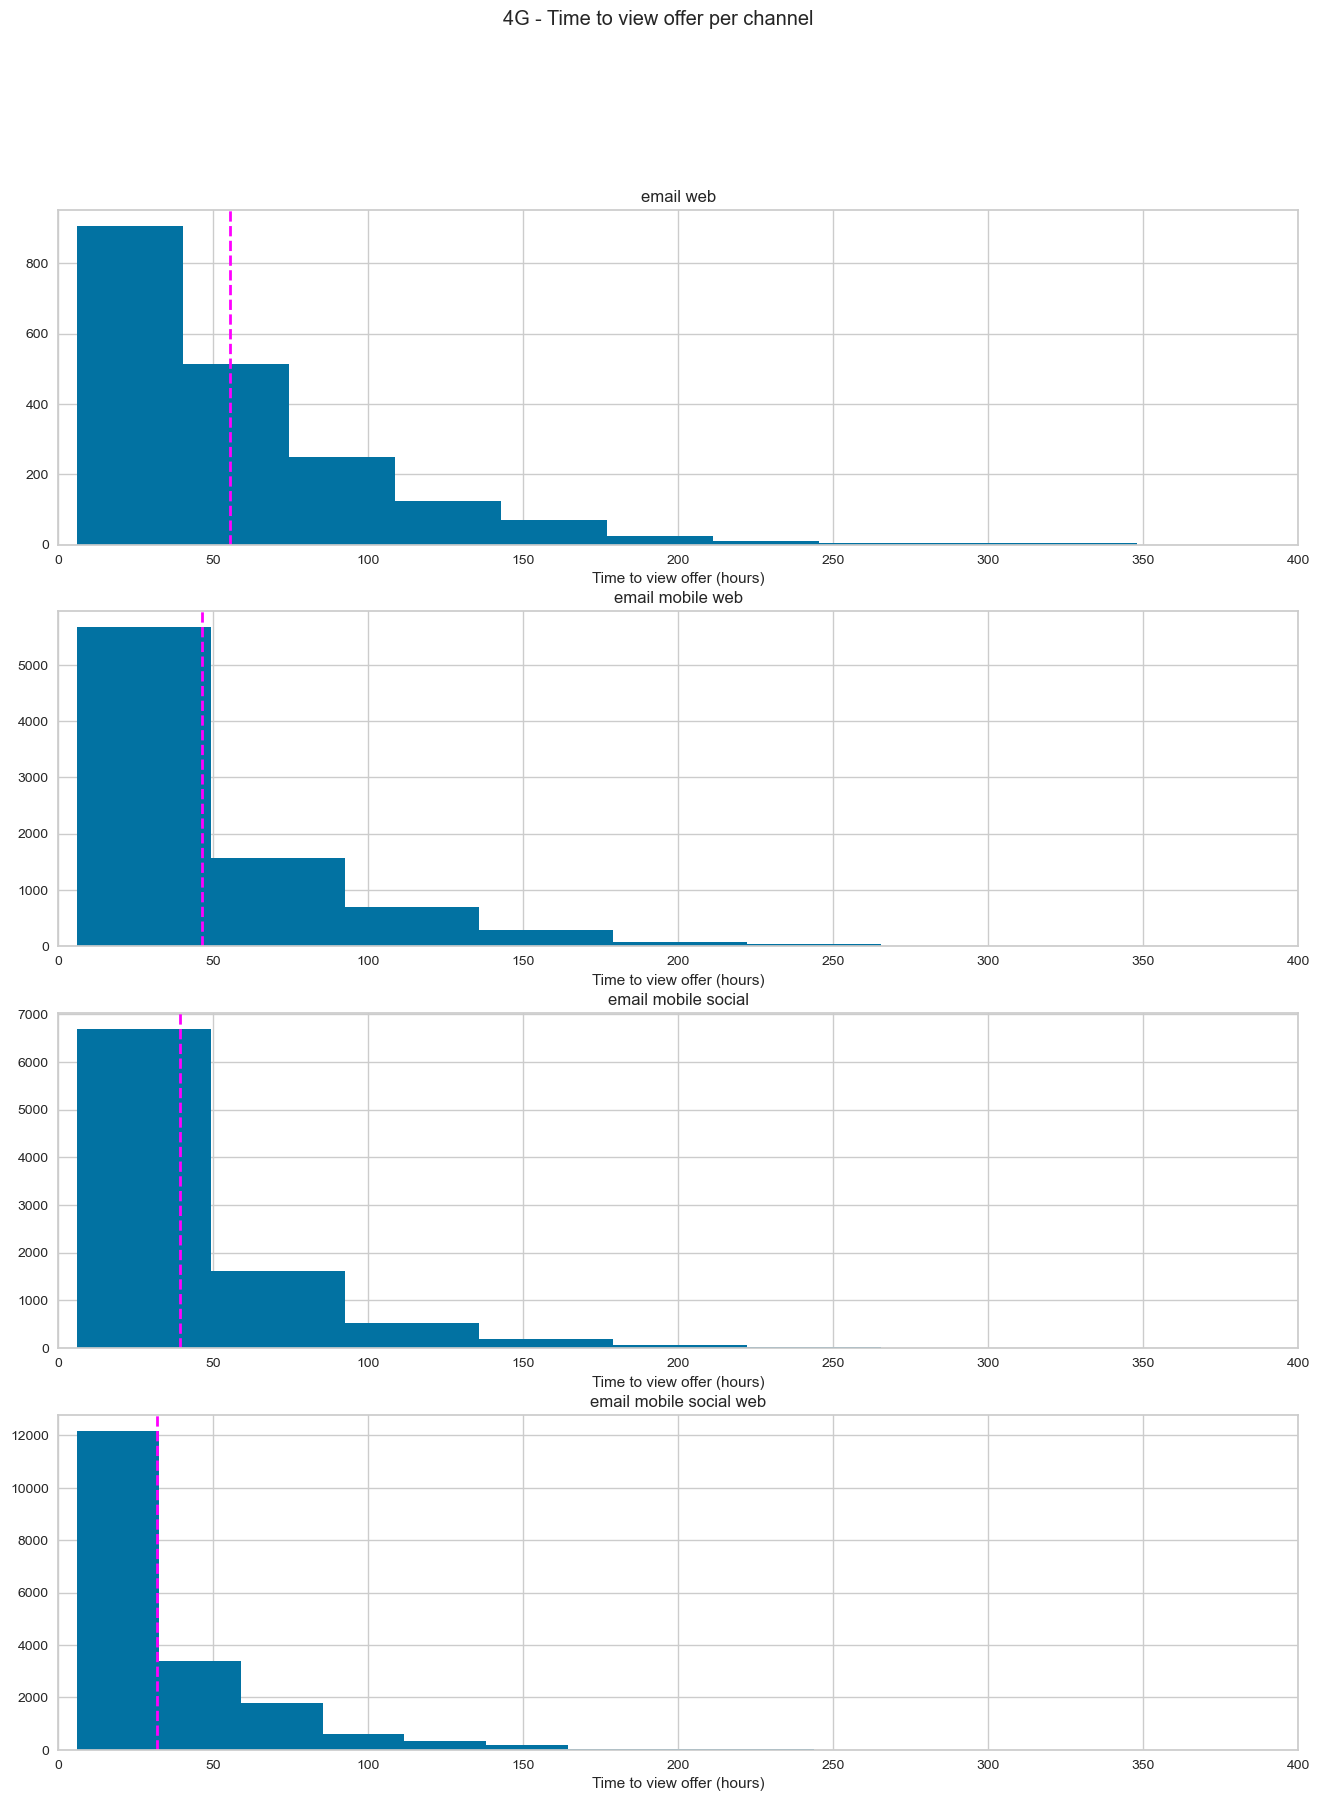

In [90]:
# Visualise customer's time to view each offer based on channels used

fig, ax = plt.subplots(4, 1, figsize=(16,20))
fig.suptitle('4G - Time to view offer per channel')

channels = ['email web', 'email mobile web', 'email mobile social', 'email mobile social web' ]

for c in range(1,len(channels)+1):
    
    plot_no = 410 + c
    plt.subplot(plot_no)
    
    view_times = consolidated[consolidated['channel_string'] == channels[c-1]]
    
    plt.hist(view_times[view_times['time_to_view'] > 0]["time_to_view"])
    plt.axvline(view_times[view_times['time_to_view'] > 0]["time_to_view"].mean(), 
                color='magenta', linestyle='dashed', linewidth=2)
    plt.title(channels[c-1])
    plt.xlabel("Time to view offer (hours)")
    ax = plt.gca()
    ax.set_xlim(0,400)
    

* Figure 4G - **Time to view** shows us how where the most likely place is for customers to see an offer. Since the channels are grouped together in the data, it is difficult to see the direct influence each channel has on how quickly an offer was viewed. 
    - What we can see is that the more platforms are used, the more likely a customer will see the offer. 
    - As excpected, the offers that were sent with only an email and web had an average time_to_view of over 50 hours.
    - Adding mobile to that took the time_to_view to just under 50 hours. 
    - The most effective method of getting views was including a social platform which took the time_to_view to about just over a day. 

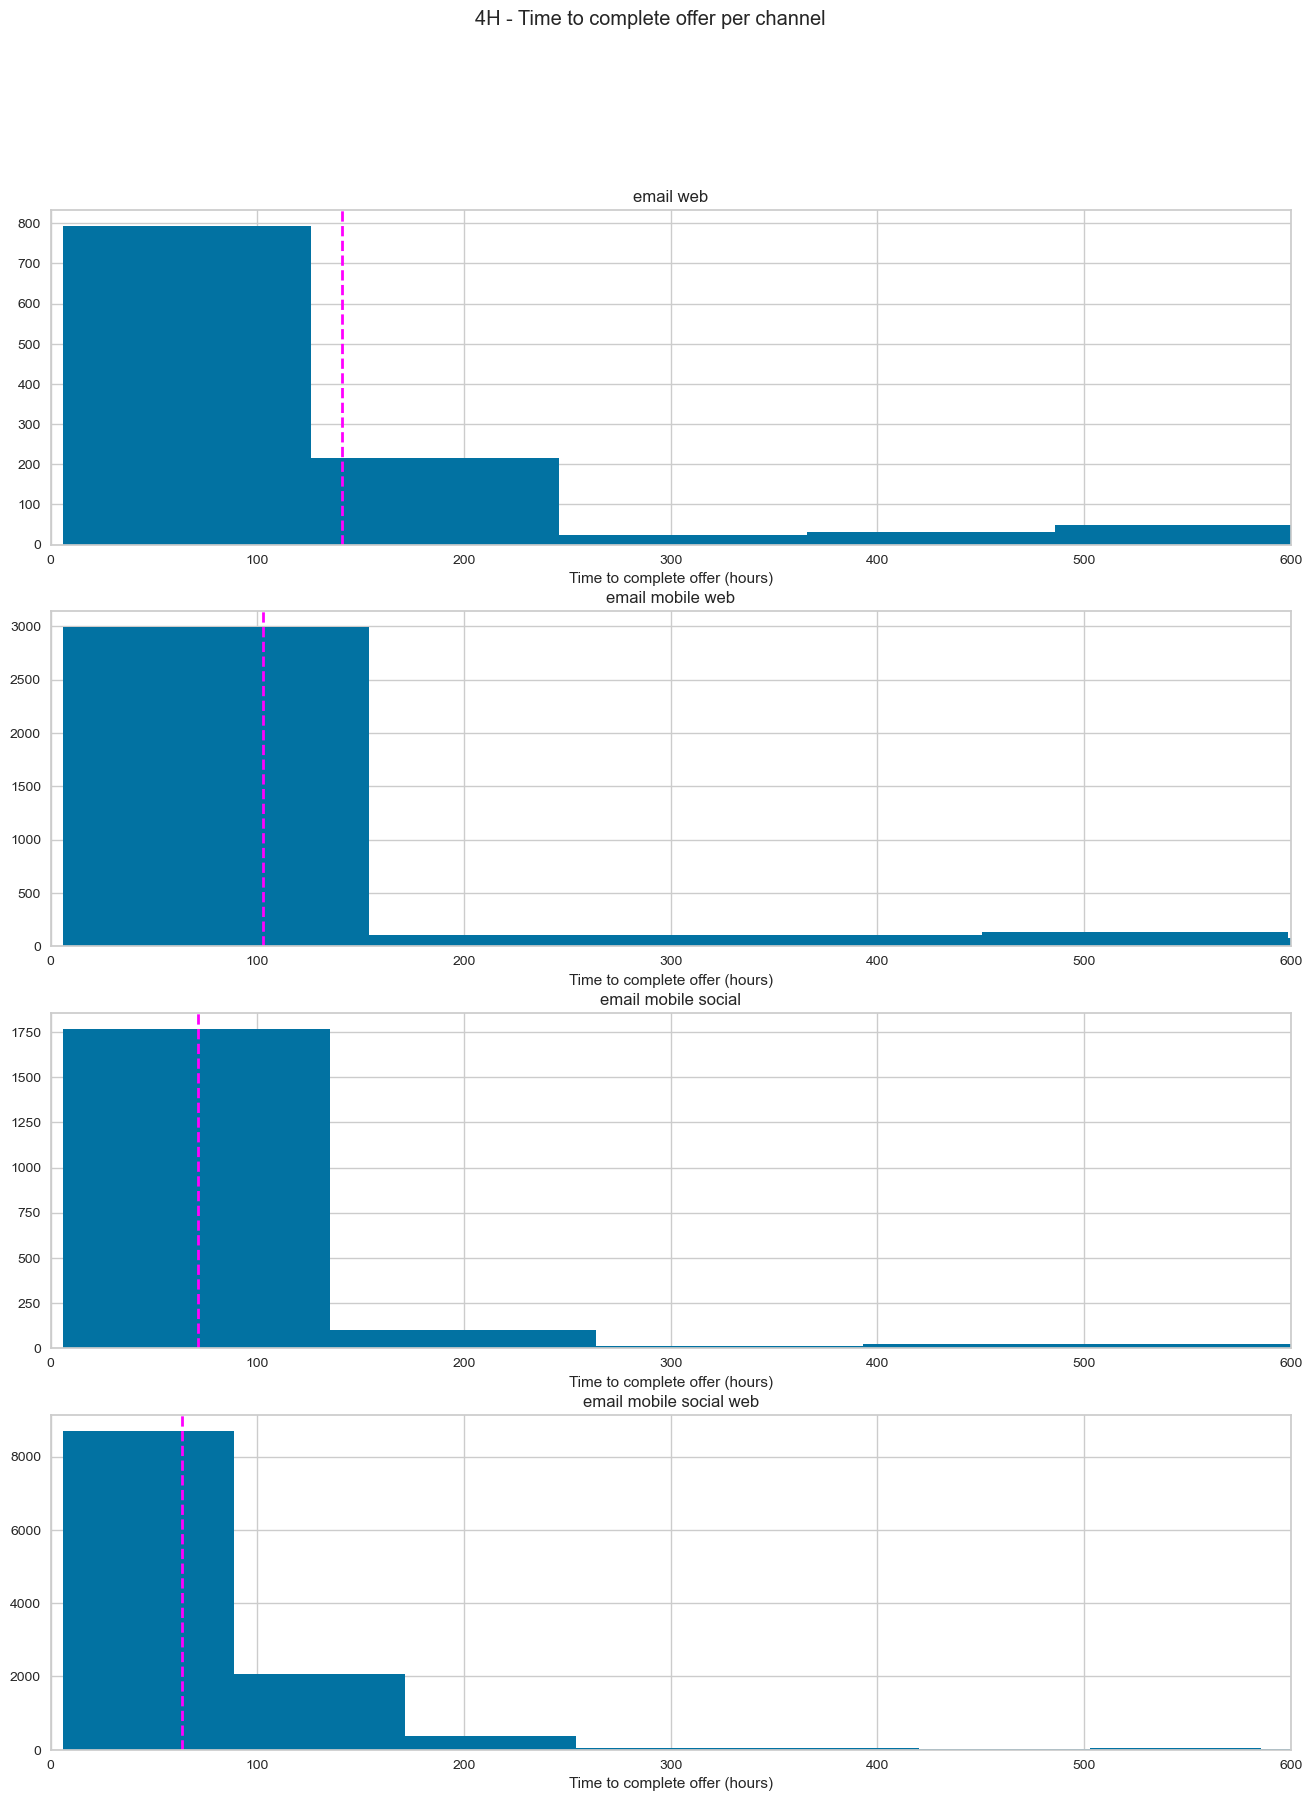

In [91]:
# Visualise customer's time to view each offer based on channels used

fig, ax = plt.subplots(4, 1, figsize=(16,20))
fig.suptitle('4H - Time to complete offer per channel')

for c in range(1,len(channels)+1):
    
    plot_no = 410 + c
    plt.subplot(plot_no)
    
    complete_times = consolidated[consolidated['channel_string'] == channels[c-1]]
    
    plt.hist(complete_times[complete_times['time_to_complete'] > 0]["time_to_complete"])
    plt.axvline(complete_times[complete_times['time_to_complete'] > 0]["time_to_complete"].mean(), 
                color='magenta', linestyle='dashed', linewidth=2)
    plt.title(channels[c-1])
    plt.xlabel("Time to complete offer (hours)")
    ax = plt.gca()
    ax.set_xlim(0,600)

* Figure 4H - **Time to complete** can be used to determine how effective the offer is at driving action from those who have viewed it, and how easy it is to go out and complete the offer once it has been viewed. 
    - Email and web gets the customer to complete the offer in an average of 5 days. This is ineffective for offers with shorter validy periods
    - Adding mobile into the offer gets customers purchasing within 4 days of seeing the offer
    - Adding a social element is the most effective at getting the customer to make the purchase within about 3 days of seeing it.

# Section 5: Conclusion <a name="conclusion"></a>

## Reflection <a name="reflection"></a>

This project involved a lot of logical thinking in how to merge 3 distint datasets in such a way that told a story and enabled us to draw insights into the customers, the offers and how to make those offers more successful. Customers were grouped together based on an unsupervised machine learning technique - this required some additional research and learning about the elbow method and silhouette plots. Once the customers were segmented it was easy to see which offers they responded best to and which offers successfully influenced them to spend money. The method of presenting the offers also greatly affects which offers would be succesful - the ones that can be viewed quickly and drive the customers to action are the ones that make you money.  

## Improvement <a name="Improvement"></a>

Gender is an important factor when it comes to rewards and spending behaviour. Unfortunately the clustering algorithm that was used is not able to consider categorical features such as gender. In future iterations of the this project, other algorithms and techniques could be incorporated which consider additional features. 